# Selfie dataset exploration

* Data Source: http://crcv.ucf.edu/data/Selfie/ (Download link w images + labels. Total size of images is 1+GB)

Steps

1. We relabel datasets based on popularity scores & binary features (to eliminate noise and for simplicity)
2. We used to recategorize images based on their new categorical labels - at the end of this script
3. After images have been categorized into various folders based on their labels,


* we train an image classifier by retraining a MobileNet CNN model
* for more info on specific details, see ["TensorFlow for Poets 2" Codelab](https://codelabs.developers.google.com/codelabs/tensorflow-for-poets-2)

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
tablefile = "selfie_dataset.txt"
colnames = ["id", "pop", ] + ["partial", "female", "baby", "child", "teenager", "youth", "middle_age", \
                              "senior", "white", "black", "asian", "oval_face", "round_face", "heart_face", "smiling", \
                              "mouth_open", "frowning", "wearing_glasses", "wearing_sunglasses", "wearing_lipstick", \
                              "tongue_out", "duck_face", "black_hair", "blond_hair", "brown_hair", "red_hair", \
                              "curly_hair", "straight_hair", "braid_hair", "showing_cellphone", "using_earphone", \
                              "using_mirror", "braces", "wearing_hat", "harsh_lighting", "dim_lighting"]

In [3]:
t = pd.read_csv(tablefile, delimiter=" ", names = colnames)

# Characteristics of bad selfies
t['pred'] = np.where(((t.partial==1) | (t.harsh_lighting==1) | (t.dim_lighting==1) | ((t.duck_face==1) & (t['pop'] < 4.7)) | \
                      (t.showing_cellphone==1) | (t.frowning==1)), -1, 0)

# Characteristics of good selfies
t['yeah'] = np.where(((t.pred == 0) & (t['pop'] > 3) & ((t.smiling==1) | (t['pop'] > 4.8))), 1, 0)
t.loc[t.yeah == 1,'pred'] = 1
print t['pred'].shape
# print t.pred.value_counts()

(46836,)


# Some exploration code that led us to conclude ^ the above characteristics

In [4]:
t = t[["id","pop","pred","yeah","female","heart_face","smiling","wearing_hat","tongue_out","duck_face","showing_cellphone","frowning","partial","harsh_lighting","dim_lighting"]]
t.describe()

,pop,pred,yeah,female,heart_face,smiling,wearing_hat,tongue_out,duck_face,showing_cellphone,frowning,partial,harsh_lighting,dim_lighting
count,46836.000000,46836.000000,46836.000000,46836.000000,46836.000000,46836.000000,46836.000000,46836.000000,46836.000000,46836.000000,46836.000000,46836.000000,46836.00000,46836.00000
mean,4.373865,-0.090166,0.289179,0.471496,-0.767316,-0.478734,-0.901144,-0.964429,-0.889743,-0.767060,-0.980869,-0.577590,-0.88970,-0.88970
std,0.591947,0.812655,0.453386,0.862179,0.641276,0.877969,0.433524,0.264345,0.456467,0.641583,0.194669,0.816336,0.45655,0.45655
min,1.656000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.00000
25%,3.989000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.00000
50%,4.379000,0.000000,0.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.00000
75%,4.768000,1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.00000
max,6.714000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000


In [5]:
short = t[["id","pop","female","pred"]][t['pop'] > 4][t.pred == 1]
s = short.sort_values(['pop'], ascending=[False])
print s.shape
s.head()

(11767, 4)


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,id,pop,female,pred
16010,10246193_759902524032108_1348424338_a,6.714,1,1
39120,1963114_301256976694700_2141824347_a,6.675,-1,1
35470,1530880_228950607299048_780223704_a,6.647,1,1
18928,10251490_624463514296682_1569950976_a,6.567,-1,1
36285,1596805_642624365807253_25061753_a,6.511,1,1


In [6]:
names = s["id"].head(20).as_matrix()
img_folder_path = 'images/'
imgPaths = [img_folder_path+name+".jpg" for name in names]
print(imgPaths[:5])

['images/10246193_759902524032108_1348424338_a.jpg', 'images/1963114_301256976694700_2141824347_a.jpg', 'images/1530880_228950607299048_780223704_a.jpg', 'images/10251490_624463514296682_1569950976_a.jpg', 'images/1596805_642624365807253_25061753_a.jpg']


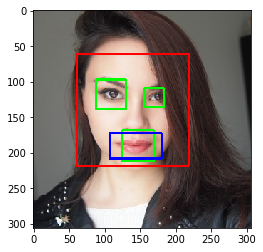

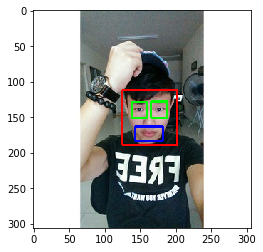

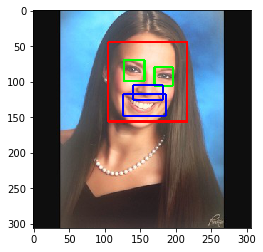

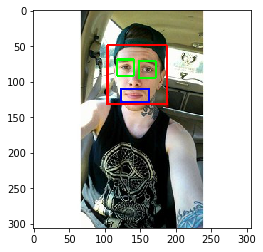

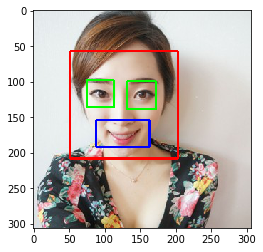

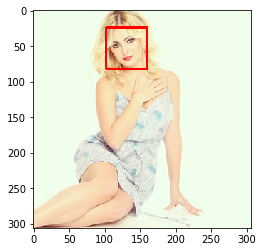

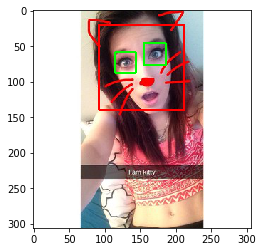

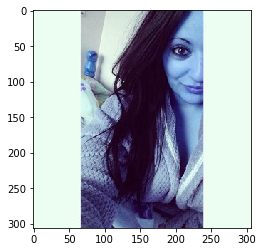

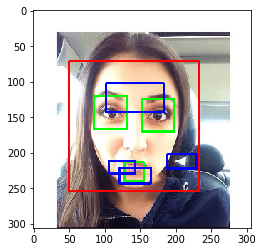

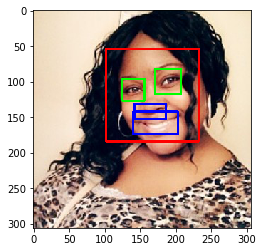

In [7]:
for img in imgPaths[:10]:
    img = cv2.imread(img)
    
    face_cascade = cv2.CascadeClassifier("utils/haarcascade_frontalface_default.xml")
    eye_cascade = cv2.CascadeClassifier('utils/haarcascade_eye.xml')
    smile_cascade = cv2.CascadeClassifier('utils/haarcascade_smile.xml')
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    detected_faces = face_cascade.detectMultiScale(gray)
    
    for(x, y, w, h) in detected_faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        
        eyes = eye_cascade.detectMultiScale(roi_gray)
        smile = smile_cascade.detectMultiScale(roi_gray)
   
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

        for (ex,ey,ew,eh) in eyes:
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
            
        for (sx,sy,sw,sh) in smile:
            cv2.rectangle(roi_color,(sx,sy),(sx+sw,sy+sh),(0,0,255),2)

        plt.imshow(img)
        plt.show()
    if len(detected_faces) == 0:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()

# Export labelled ids (yeah/nope) to .txt files

In [21]:
x = t[t.pred == 1]["id"].as_matrix()
with open("yeah.txt","w") as f:
    for name in x:
        f.write(name+"\n");

In [22]:
x = t[t.pred == -1]["id"].as_matrix()
with open("nope.txt","w") as f:
    for name in x:
        f.write(name+"\n");

# Re-categorize images into respective folders based on labels in .txt

In [ ]:
from shutil import copyfile

In [ ]:
src="images/"
dst="selfies/"
cats=["yeah","nope"]

In [ ]:
i=0
for cat in cats:
    with open(cat + ".txt", "r") as f:
        for line in f:
            picid = line.split(" ")[0][:-1]
            start = src + picid + ".jpg"
            end = dst + cat + "/" + picid + ".jpg"
            copyfile(start,end)
            i = i + 1
            if(i % 1000 == 0):
                print str(i) + " ",
    print str(cat) + " done."